In [1]:
import SimpleITK as sitk 
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import measure 
from pathlib import Path

def reorient_image_to_itk_snap_view(im : str | Path | sitk.Image):
    if isinstance(im, str) or isinstance(im, Path):
        im_sitk = sitk.ReadImage(im)
    else:
        im_sitk = im
    spacing = im_sitk.GetSpacing()
    aspect = spacing[1] / spacing[0]
    # print(f"Original image size: {im_sitk.GetSize()}")
    im_sitk = sitk.DICOMOrient(im_sitk, "LPI")
    # print(f"Reoriented image size: {im_sitk.GetSize()}")
    im_sitk = sitk.GetArrayFromImage(im_sitk)
    # print(f"Image shape after GetArrayFromImage: {im_sitk.shape}")
    im_sitk = np.moveaxis(im_sitk, 0, -1)
    # print(f"Image shape after moveaxis: {im_sitk.shape}")
    im_sitk = im_sitk[:, :, ::-1]
    # print(f"Image shape after flipping: {im_sitk.shape}")

    return im_sitk, aspect

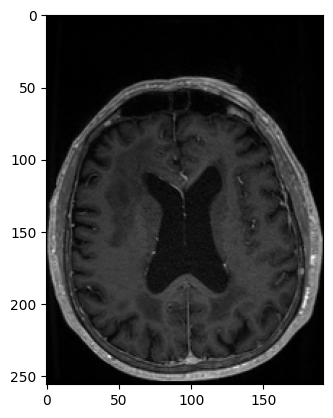

In [2]:
im_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients/IM1392/NIFTI/T1GD.nii.gz"
im_sitk, _ = reorient_image_to_itk_snap_view(im_dir)
plt.imshow(im_sitk[:, :, 149], cmap="gray")

In [3]:
def reorient_and_visualize_itk_snap_view(
    im_dir: str, library: str, slice_number: int
) -> None:
    """
    Reorient a medical image to ITK-SNAP view (LPI) and visualize axial, sagittal, and coronal slices.

    Args:
        im_dir (str): Path to the image file.
        library (str): Library to use for loading the image. Must be either 'nibabel' or 'SimpleITK'.
        slice_number (int): Index of the slice to visualize in each plane.

    Returns:
        None: Displays matplotlib figures with the selected slices.

    Raises:
        AssertionError: If library is not 'nibabel' or 'SimpleITK'.
    """
    assert library in [
        "nibabel",
        "SimpleITK",
    ], "Library must be either 'nibabel' or 'SimpleITK'"

    if library == "nibabel":
        im_arr = nib.load(im_dir).get_fdata()
    else:
        im_arr = sitk.GetArrayFromImage(sitk.ReadImage(im_dir))

    im_arr = np.flip(im_arr, axis=(0, 1, 2))

    if library == "nibabel":
        print(im_arr.shape)
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(im_arr[:, :, im_arr.shape[2] - 1 - slice_number].T, cmap="gray")
        plt.title(f"Axial slice {slice_number}")
        plt.subplot(1, 3, 2)
        plt.imshow(im_arr[im_arr.shape[0] - 1 - slice_number, :, :].T, cmap="gray")
        plt.title(f"Sagittal slice {slice_number}")
        plt.subplot(1, 3, 3)
        plt.imshow(im_arr[:, im_arr.shape[1] - 1 - slice_number, :].T, cmap="gray")
        plt.title(f"Coronal slice {slice_number}")
    else:
        print(im_arr.shape)
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(np.flip(im_arr[im_arr.shape[0] - 1 - slice_number, :, :],axis=1), cmap="gray")
        plt.title(f"Axial slice {slice_number}")
        plt.subplot(1, 3, 2)
        plt.imshow(im_arr[:, :, im_arr.shape[2] - 1 - slice_number], cmap="gray")
        plt.title(f"Sagital slice {slice_number}")
        plt.subplot(1, 3, 3)
        plt.imshow(np.flip(im_arr[:, im_arr.shape[1] - 1 - slice_number, :], axis=1), cmap="gray")
        plt.title(f"Coronal slice {slice_number}")

(256, 256, 192)


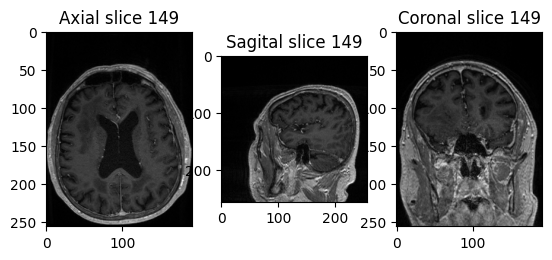

In [4]:
im_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients/IM1392/NIFTI/T1GD.nii.gz"
reorient_and_visualize_itk_snap_view(im_dir, library="SimpleITK", slice_number=149)

In [5]:
from pathlib import Path 
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap([
    (0, 0, 0, 0),        # 0 → transparent
    "orange",           # 1 → orange
    "purple",           # 2 → purple
    "blue",             # 3 → blue
])

def plot_ensemble_segmentation_and_gt_overlayed(
        case_id: str, 
        patients_dir: str | Path, 
        gt_dir : str | Path,
        slice_number: int,
        output_dir: str | Path = None
):
    """
    Plot ensemble segmentation and ground truth overlayed on original image for axial, sagittal, and coronal slices.
    
    Args:
        case_id (str): Identifier for the patient case.
        patients_dir (str | Path): Directory containing patient data.
        gt_dir (str | Path): Directory containing ground truth segmentations.
        slice_number (int): Axial slice number to visualize.

    """
    if isinstance(patients_dir, str):
        patients_dir = Path(patients_dir)
    if isinstance(gt_dir, str):
        gt_dir = Path(gt_dir)
    if isinstance(output_dir, str):
        output_dir = Path(output_dir)
    
    t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
    t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
    t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
    flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"
    seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1GD.nii.gz"
    gt_dir = gt_dir / case_id / "NIFTI" / "MASK_original.nii.gz"

    if not gt_dir.exists():
        gt_dir = gt_dir.parent / "MASK.nii.gz"
    
    # Now we create a 2x3 plot where we wil have: axial slice with gt, axial slice with seg, sagittal slice with gt, sagittal slice with seg, coronal slice with gt, coronal slice with seg.

    t1gd_im = sitk.ReadImage(t1gd_im_dir)
    t1_im = sitk.ReadImage(t1_im_dir)
    t2_im = sitk.ReadImage(t2_im_dir)
    flair_im = sitk.ReadImage(flair_im_dir)

    # Now we resample all images to the t1gd image space
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(t1gd_im)
    resampler.SetInterpolator(sitk.sitkLinear)
    t1_im_resampled = resampler.Execute(t1_im)
    t2_im_resampled = resampler.Execute(t2_im)
    flair_im_resampled = resampler.Execute(flair_im)


    orig_im, orig_aspect = reorient_image_to_itk_snap_view(t1gd_im_dir)
    t1_im, _ = reorient_image_to_itk_snap_view(t1_im_resampled)
    t2_im, _ = reorient_image_to_itk_snap_view(t2_im_resampled)
    flair_im, _ = reorient_image_to_itk_snap_view(flair_im_resampled)
    seg_im, _ = reorient_image_to_itk_snap_view(seg_dir)
    gt_im, _ = reorient_image_to_itk_snap_view(gt_dir)

    colors_okaito = ["#E69F00", "#56B4E9", "#D55E00"]


    plt.figure()

    # T1 image alone
    plt.subplot(4,3,1)
    plt.axis('off')
    plt.imshow(t1_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)

    # T1 image with GT overlay
    plt.subplot(4,3,2)
    plt.axis('off')
    plt.imshow(t1_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        gt_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )

    # T1 image with SEG overlay
    plt.subplot(4,3,3)
    plt.axis('off')
    plt.imshow(t1_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        seg_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )

    # T1GD image alone
    plt.subplot(4,3,4)
    plt.axis('off')
    plt.imshow(orig_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    # plt.savefig(output_dir / f"{case_id}_orig_slice_{slice_number}.svg", bbox_inches = "tight", pad_inches=0)

    # T1GD with GT overlay
    plt.subplot(4,3,5)
    plt.axis('off')
    plt.imshow(orig_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    print(np.unique(gt_im[:, :, slice_number], return_counts=True))
    print(np.unique(seg_im[:, :, slice_number], return_counts=True))
    plt.contourf(
        gt_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )
    # plt.imshow(np.ma.masked_where(gt_im[:, :, slice_number] == 0, gt_im[:, :, slice_number]), cmap=label_cmap, alpha=0.5, aspect=orig_aspect)
    # plt.savefig(output_dir / f"{case_id}_gt_overlay_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)

    # T1GD with SEG overlay
    plt.subplot(4,3,6)
    plt.axis('off')
    plt.imshow(orig_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        seg_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )
    # plt.imshow(np.ma.masked_where(seg_im[:, :, slice_number] == 0, seg_im[:, :, slice_number]), cmap=label_cmap, alpha=0.5, aspect=orig_aspect)
    # plt.savefig(output_dir / f"{case_id}_seg_overlay_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
    
    #T2 image alone
    plt.subplot(4,3,7)
    plt.axis('off')
    plt.imshow(t2_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    
    # T2 image with GT overlay
    plt.subplot(4,3,8)
    plt.axis('off')
    plt.imshow(t2_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        gt_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )

    # T2 image with SEG overlay
    plt.subplot(4,3,9)
    plt.axis('off')
    plt.imshow(t2_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        seg_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )

    # FLAIR image alone
    plt.subplot(4,3,10)
    plt.axis('off')
    plt.imshow(flair_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)   
    
    # FLAIR image with GT overlay
    plt.subplot(4,3,11)
    plt.axis('off')
    plt.imshow(flair_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        gt_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )

    # FLAIR image with SEG overlay
    plt.subplot(4,3,12)
    plt.axis('off')
    plt.imshow(flair_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
    plt.contourf(
        seg_im[:, :, slice_number],
        levels=[0.5, 1.5, 2.5, 3.5],
        colors=colors_okaito,
        alpha=0.5,
    )
    plt.tight_layout(pad=0)
    plt.show()

In [6]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


def plot_ensemble_segmentation_and_gt_overlayed(
    case_id: str,
    patients_dir: str | Path,
    gt_dir: str | Path,
    slice_number: int,
    output_dir: str | Path = None,
):
    """
    Plot T1, T1GD, T2, FLAIR with GT and ensemble segmentation overlays.
    Layout: 4 rows × 3 columns
    """

    patients_dir = Path(patients_dir)
    gt_dir = Path(gt_dir)
    if output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # ---------------------------
    # File paths
    # ---------------------------
    t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
    t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
    t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
    flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"

    seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / \
              "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

    gt_mask = gt_dir / case_id / "NIFTI" / "MASK_original.nii.gz"
    if not gt_mask.exists():
        gt_mask = gt_mask.parent / "MASK.nii.gz"

    # ---------------------------
    # Read images
    # ---------------------------
    t1gd_itk = sitk.ReadImage(t1gd_im_dir)
    t1_itk = sitk.ReadImage(t1_im_dir)
    t2_itk = sitk.ReadImage(t2_im_dir)
    flair_itk = sitk.ReadImage(flair_im_dir)

    # Resample all to T1GD space
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(t1gd_itk)
    resampler.SetInterpolator(sitk.sitkLinear)

    t1_itk = resampler.Execute(t1_itk)
    t2_itk = resampler.Execute(t2_itk)
    flair_itk = resampler.Execute(flair_itk)

    # ---------------------------
    # Convert + reorient
    # ---------------------------
    t1gd_im, orig_aspect = reorient_image_to_itk_snap_view(t1gd_itk)
    t1_im, _ = reorient_image_to_itk_snap_view(t1_itk)
    t2_im, _ = reorient_image_to_itk_snap_view(t2_itk)
    flair_im, _ = reorient_image_to_itk_snap_view(flair_itk)
    seg_im, _ = reorient_image_to_itk_snap_view(seg_dir)
    gt_im, _ = reorient_image_to_itk_snap_view(gt_mask)

    # ---------------------------
    # Overlay colors (Okabe–Ito safe)
    # ---------------------------
    colors = ["#E69F00", "#CC79A7", "#0072B2"]  # orange, purple, blue
    levels = [0.5, 1.5, 2.5, 3.5]

    # ---------------------------
    # Plot helper
    # ---------------------------
    def show(ax, base, overlay=None):
        ax.axis("off")
        ax.set_aspect(orig_aspect)
        ax.imshow(base[:, :, slice_number], cmap="gray")
        if overlay is not None:
            ax.contourf(
                overlay[:, :, slice_number],
                levels=levels,  
                colors=colors,
                alpha=0.5,
            )

    # ---------------------------
    # Figure + layout (NO GAPS)
    # ---------------------------
    fig = plt.figure(figsize=(9, 12))
    gs = fig.add_gridspec(
        4, 3,
        left=0, right=1, bottom=0, top=1,
        wspace=-0.5, hspace=0
    )

    axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(3)] for r in range(4)])

    # Row 1 — T1
    show(axes[0, 0], t1_im)
    show(axes[0, 1], t1_im, gt_im)
    show(axes[0, 2], t1_im, seg_im)

    # Row 2 — T1CE
    show(axes[1, 0], t1gd_im)
    show(axes[1, 1], t1gd_im, gt_im)
    show(axes[1, 2], t1gd_im, seg_im)

    # Row 3 — T2
    show(axes[2, 0], t2_im)
    show(axes[2, 1], t2_im, gt_im)
    show(axes[2, 2], t2_im, seg_im)

    # Row 4 — FLAIR
    show(axes[3, 0], flair_im)
    show(axes[3, 1], flair_im, gt_im)
    show(axes[3, 2], flair_im, seg_im)

    plt.show()

    if output_dir is not None:
        fig.savefig(
            output_dir / f"{case_id}_slice_{slice_number}.svg",
            bbox_inches="tight",
            pad_inches=0,
        )
    
    plt.close(fig)

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


def plot_ensemble_segmentation_and_gt_overlayed(
    case_id: str,
    patients_dir: str | Path,
    gt_dir: str | Path,
    slice_number: int,
    output_dir: str | Path = None,
    **kwargs
):
    """
    Plot T1, T1GD, T2, FLAIR with GT and ensemble segmentation overlays.
    Layout: 4 rows × 3 columns
    """

    patients_dir = Path(patients_dir)
    gt_dir = Path(gt_dir)
    if output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # ---------------------------
    # File paths
    # ---------------------------
    t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD_original.nii.gz"
    t1_im_dir = patients_dir / case_id / "NIFTI" / "T1_original.nii.gz"
    t2_im_dir = patients_dir / case_id / "NIFTI" / "T2_original.nii.gz"
    flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR_original.nii.gz"

    if not t1gd_im_dir.exists():
        t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
    if not t1_im_dir.exists():
        t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
    if not t2_im_dir.exists():
        t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
    if not flair_im_dir.exists():
        flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"

    seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / \
              "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

    # gt_mask = gt_dir / case_id / "NIFTI" / "MASK_original.nii.gz"
    # if not gt_mask.exists():
    gt_mask = gt_dir / case_id / "NIFTI" / "MASK.nii.gz"

    # ---------------------------
    # Read images
    # ---------------------------
    t1gd_itk = sitk.ReadImage(t1gd_im_dir)
    t1_itk = sitk.ReadImage(t1_im_dir)
    t2_itk = sitk.ReadImage(t2_im_dir)
    flair_itk = sitk.ReadImage(flair_im_dir)

    # Resample all to T1GD space
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(t1gd_itk)
    resampler.SetInterpolator(sitk.sitkLinear)

    t1_itk = resampler.Execute(t1_itk)
    t2_itk = resampler.Execute(t2_itk)
    flair_itk = resampler.Execute(flair_itk)

    # ---------------------------
    # Convert + reorient
    # ---------------------------
    t1gd_im, orig_aspect = reorient_image_to_itk_snap_view(t1gd_itk)
    t1_im, _ = reorient_image_to_itk_snap_view(t1_itk)
    t2_im, _ = reorient_image_to_itk_snap_view(t2_itk)
    flair_im, _ = reorient_image_to_itk_snap_view(flair_itk)
    seg_im, _ = reorient_image_to_itk_snap_view(seg_dir)
    gt_im, _ = reorient_image_to_itk_snap_view(gt_mask)

    # ---------------------------
    # Overlay colors (Okabe–Ito safe)
    # ---------------------------
    colors = ["#E69F00", "#CC79A7", "#0072B2"]  # orange, purple, blue
    levels = [0.5, 1.5, 2.5, 3.5]

    # ---------------------------
    # Plot helper
    # ---------------------------
    def show(ax, base, overlay=None):
        ax.axis("off")
        ax.imshow(base[:, :, slice_number], cmap="gray", aspect=orig_aspect)
        if overlay is not None:
            ax.contourf(
                overlay[:, :, slice_number],
                levels=levels,  
                colors=colors,
                alpha=0.7
            )


    # ---------------------------
    # Figure + layout (NO GAPS)
    # ---------------------------

    fig = plt.figure()
    gs = fig.add_gridspec(
        2, 4,
        left=0, right=1, bottom=0, top=1,
        **kwargs
    )

    axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(4)] for r in range(2)])

    # Row 1 — T1, T1CE, T1CE + GT, T1CE + SEG
    show(axes[0, 0], t1_im)
    show(axes[0, 1], t1gd_im)
    show(axes[0, 2], t1gd_im, gt_im)
    show(axes[0, 3], t1gd_im, seg_im)

    # Row 2 — T2, FLAIR, FLAIR + GT, FLAIR + SEG
    show(axes[1, 0], t2_im)
    show(axes[1, 1], flair_im)
    show(axes[1, 2], flair_im, gt_im)
    show(axes[1, 3], flair_im, seg_im)

    plt.show()

    if output_dir is not None:
        fig.savefig(
            output_dir / f"{case_id}_slice_{slice_number}.svg",
            bbox_inches="tight",
            pad_inches=0,
        )
    
    plt.close(fig)

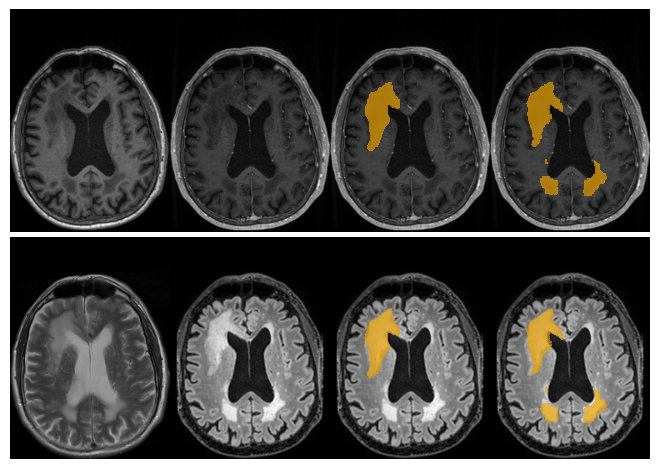

In [8]:
patients_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients"
output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)
gt_dir = "/scratch/radv/share/glioseg/new_run_corrected/GT"
# case_ids = ["IM1392", "IM1389", "IM0256", "IM0031", "IM1420"]
# slice_numbers = [148, 139, 260, 361, 126]
# hspace = [-0.15, -0.15, -0.08, -0.2, 

# case_ids = ["IM1420"]
# slice_numbers = [126]
case_ids = ["IM1392"]
slice_numbers = [148]


for case_id, slice_number in zip(case_ids, slice_numbers):
    plot_ensemble_segmentation_and_gt_overlayed(
        case_id,
        patients_dir,
        gt_dir,
        slice_number,
        output_dir,
        wspace = 0, 
        hspace = -0.1
    )

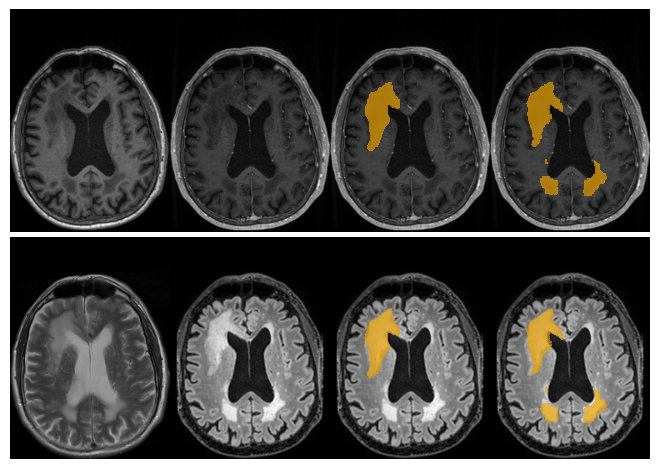

In [9]:
patients_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients"
output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)
gt_dir = "/scratch/radv/share/glioseg/new_run_corrected/GT"
# case_ids = ["IM1392", "IM1389", "IM0256", "IM0031", "IM1420"]
# slice_numbers = [148, 139, 260, 361, 126]
# hspace = [-0.15, -0.15, -0.08, -0.2, 

# case_ids = ["IM1420"]
# slice_numbers = [126]
case_ids = ["IM1392"]
slice_numbers = [148]


for case_id, slice_number in zip(case_ids, slice_numbers):
    plot_ensemble_segmentation_and_gt_overlayed(
        case_id,
        patients_dir,
        gt_dir,
        slice_number,
        output_dir,
        wspace = 0, 
        hspace = -0.1
    )

In [10]:
import os
gt_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/GT/")

for patients in gt_dir.iterdir(): 
    nifti_dir = patients / "NIFTI"
    print(len(list(os.listdir(nifti_dir))))

2
2
1
1
1
1
1
2
2
1
2
1
2
1
1
1
1
2
1
1
1
2
1
1
1
1
3
2
1
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2


In [11]:
from pathlib import Path 
import glioseg.constants as constants
import glioseg.IO.config as configIO
import shutil 

def fix_physical_space(config: str | Path | configIO.Config):
    """
    Ensures GT has same physical space metadata as original T1GD scan.

    Args:
        config: configIO.Config instance or path.
    """
    if isinstance(config, str) or isinstance(config, Path):
        config = configIO.Config(config)
    i_patient_folder = config.input_data_path.joinpath("IM0398")

    # for i_patient_folder in config.input_data_path.iterdir():
    ref_scan_path = i_patient_folder.joinpath(
        constants.NIFTI_FOLDER_NAME, config.gt_modality
    ).with_suffix(constants.NIFTI_EXTENSION)

    gt_mask_path = config.gt_data_path.joinpath(
        i_patient_folder.name, constants.NIFTI_FOLDER_NAME, constants.GT_MASK_NAME
    ).with_suffix(constants.NIFTI_EXTENSION)

    ref_scan = sitk.ReadImage(str(ref_scan_path))
    gt_mask = sitk.ReadImage(str(gt_mask_path), sitk.sitkUInt8)

    same_spacing = ref_scan.GetSpacing() == gt_mask.GetSpacing()
    same_origin = ref_scan.GetOrigin() == gt_mask.GetOrigin()
    same_direction = ref_scan.GetDirection() == gt_mask.GetDirection()

    if same_spacing and same_origin and same_direction:
        print("Same everything")
        return

    print(f" Same spacing: {same_spacing}")
    print(f" Same origin: {same_origin}")
    print(f" Same direction: {same_direction}")

    original_gt_path = config.gt_data_path.joinpath(
        i_patient_folder.name,
        constants.NIFTI_FOLDER_NAME,
        constants.GT_MASK_NAME + constants.ORIGINAL_NAME,
    ).with_suffix(constants.NIFTI_EXTENSION)
    shutil.move(str(gt_mask_path), str(original_gt_path))

    # reshape the 9‐element direction tuples into 3×3
    ref_dir = np.array(ref_scan.GetDirection()).reshape(3, 3)
    gt_dir = np.array(gt_mask.GetDirection()).reshape(3, 3)

    # compare the diagonal of the two direction matrices to see where the sign differs
    # (i.e. an axis flip)
    flip_axes = [(ref_dir[i, i] * gt_dir[i, i]) < 0 for i in range(3)]

    # if any axis needs flipping, apply it
    if any(flip_axes):
        vec_flip_axes = sitk.VectorBool()
        [vec_flip_axes.append(bool(b)) for b in flip_axes]

        flipper = sitk.FlipImageFilter()
        flipper.SetFlipAxes(vec_flip_axes)
        gt_mask = flipper.Execute(gt_mask)

    gt_mask.CopyInformation(ref_scan)
    sitk.WriteImage(gt_mask, str(gt_mask_path))


In [12]:
config = Path("/home/radv/gemosquerarojas/glioseg/glioseg/configs/luna.yml")

fix_physical_space(config)

Same everything


In [13]:
overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
gt_mask_path = "/scratch/radv/share/glioseg/new_run_corrected/GT/IM0398/NIFTI/MASK.nii.gz"
pred_mask_path = "/scratch/radv/share/glioseg/new_run_corrected/Patients/IM0398/SEGMENTATIONS/NIFTI/mask_tumor_ensemble_relabelled_T1GD.nii.gz"
gt_mask = sitk.ReadImage(gt_mask_path, sitk.sitkUInt8)
pred_mask = sitk.ReadImage(pred_mask_path, sitk.sitkUInt8)

overlap_filter.Execute(gt_mask, pred_mask)
dice = overlap_filter.GetDiceCoefficient(1)
print(f"Dice coefficient: {dice}")


Dice coefficient: 0.6622018016634957


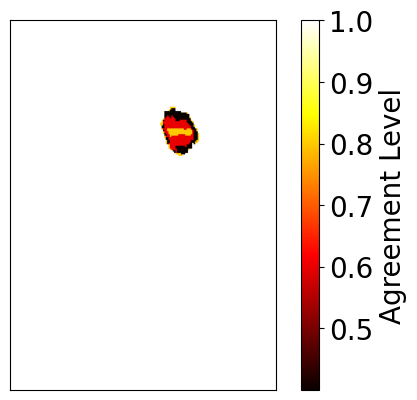

In [14]:
# Now we are going to plot the heatmap in hot cmap 

heatmap_referral_case_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/SEG_QA/AGREEMENT_STAPLE_HEATMAP/IM1411_T1GD.nii.gz")
heatmap_im, heatmap_aspect = reorient_image_to_itk_snap_view(heatmap_referral_case_dir)
# heatmap_im = np.ma.masked_where(heatmap_im == 0, heatmap_im)
plt.imshow(heatmap_im[:, :, 157], cmap="hot", aspect=heatmap_aspect)
# add the colorbar 
cbar = plt.colorbar()
cbar.set_label("Agreement Level", fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig("/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES/IM1411_agreement_heatmap_slice_157.svg", bbox_inches="tight", pad_inches=0)
plt.show()

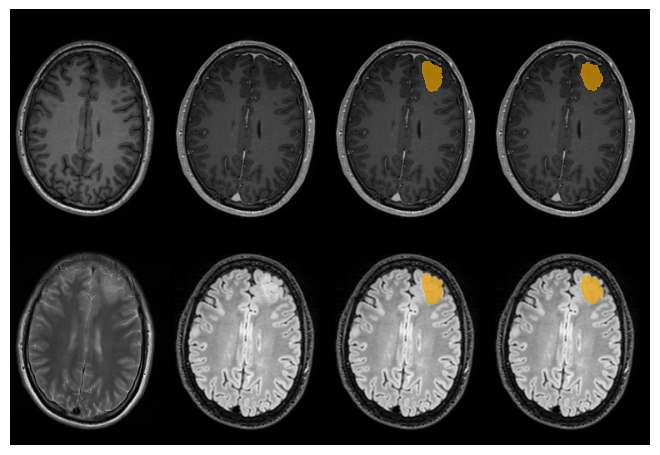

In [15]:
case_ids = ["IM1411"]
slice_numbers = [157]
for case_id, slice_number in zip(case_ids, slice_numbers):
    plot_ensemble_segmentation_and_gt_overlayed(
        case_id,
        patients_dir,
        gt_dir,
        slice_number,
        output_dir,
        wspace = 0, 
        hspace = -0.2
    )

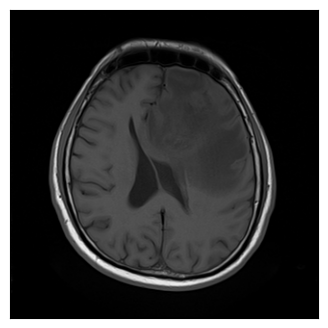

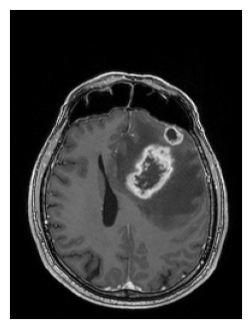

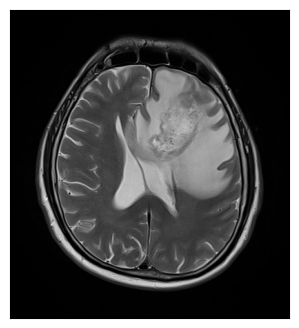

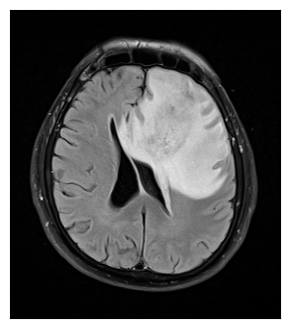

In [16]:
# Framework figures for paper

output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)

patients_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")

case_id = "IM0031"

# First: raw data 

t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
t1_im, t1_aspect = reorient_image_to_itk_snap_view(t1_im_dir)
plt.figure(figsize=(4,4))
plt.imshow(t1_im[:, :, 15], cmap="gray", aspect=t1_aspect)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T1_slice_15.svg", bbox_inches="tight", pad_inches=0)
plt.show()


t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
t1gd_im, t1gd_aspect = reorient_image_to_itk_snap_view(t1gd_im_dir)
plt.figure(figsize=(4,4))
plt.imshow(t1gd_im[:, :, 352], cmap="gray", aspect=t1gd_aspect)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T1GD_slice_352.svg", bbox_inches="tight", pad_inches=0)
plt.show()

t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
t2_im, t2_aspect = reorient_image_to_itk_snap_view(t2_im_dir)
plt.figure(figsize=(4,4))
plt.imshow(t2_im[:, :, 15], cmap="gray", aspect=t2_aspect)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T2_slice_15.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure(figsize=(4,4))
flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"
flair_im, flair_aspect = reorient_image_to_itk_snap_view(flair_im_dir)
plt.imshow(flair_im[:, :, 15], cmap="gray", aspect=flair_aspect)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_FLAIR_slice_15.svg", bbox_inches="tight", pad_inches=0)
plt.show()


In [17]:
# Now we plot all the figures in the ATLAS folder

output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)

patients_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")

case_id = "IM0031"

# First: raw data 

t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"


In [18]:
def plot_four_figures_together(t1_im, t1gd_im, t2_im, flair_im, slice_number: int, **kwargs):

    def show(ax, base, aspect):
            ax.axis("off")
            ax.imshow(base[:, :, slice_number], cmap="gray", aspect=aspect)

    fig = plt.figure()
    gs = fig.add_gridspec(
        2, 2,
        left=0, right=1, bottom=0, top=1,
        **kwargs
    )

    axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(2)] for r in range(2)])

    # Row 1 — T1, T1CE
    show(axes[0, 0], t1_im)
    show(axes[0, 1], t1gd_im)


    # Row 2 — T2, FLAIR
    show(axes[1, 0], t2_im)
    show(axes[1, 1], flair_im)

    plt.show()

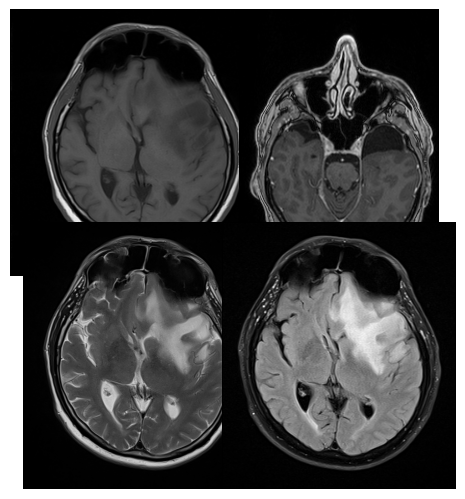

In [19]:
fig = plt.figure()
gs = fig.add_gridspec(
    2, 2,
    left=0, right=1, bottom=0, top=1,
    wspace=-0.56, hspace=-0.2
)
axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(2)] for r in range(2)])
axes[0,0].imshow(t1_im[:, :, int(t1_im.shape[2] / 2)], cmap="gray", aspect=t1_aspect)
axes[0,0].axis("off")
axes[0,1].imshow(t1gd_im[:, :, int(t1gd_im.shape[2] / 2)], cmap="gray", aspect=t1gd_aspect)
axes[0,1].axis("off")
axes[1,0].imshow(t2_im[:, :, int(t2_im.shape[2] / 2)], cmap="gray", aspect=t2_aspect)
axes[1,0].axis("off")
axes[1,1].imshow(flair_im[:, :, int(flair_im.shape[2] / 2)], cmap="gray", aspect=flair_aspect)
axes[1,1].axis("off")
plt.savefig(Path(output_dir) / f"{case_id}_four_modalities_slice_{int(t1_im.shape[2] / 2)}.svg", bbox_inches="tight", pad_inches=0)
plt.show()


In [20]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


def plot_four_figures(
    case_id: str,
    t1_im_dir, 
    t1gd_im_dir,
    t2_im_dir,
    flair_im_dir,
    slice_number: int,
    output_dir: str | Path = None,
    together: bool = True,
    **kwargs
):
    """
    Plot T1, T1GD, T2, FLAIR with GT and ensemble segmentation overlays.
    Layout: 4 rows × 3 columns
    """

    # ---------------------------
    # Read images
    # ---------------------------

    t1_itk = sitk.ReadImage(t1_im_dir)
    t1gd_itk = sitk.ReadImage(t1gd_im_dir)
    t2_itk = sitk.ReadImage(t2_im_dir)
    flair_itk = sitk.ReadImage(flair_im_dir)
    
    # Resample all to T1GD space
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(t1gd_itk)
    resampler.SetInterpolator(sitk.sitkLinear)

    t1_itk = resampler.Execute(t1_itk)
    t2_itk = resampler.Execute(t2_itk)
    flair_itk = resampler.Execute(flair_itk)

    # ---------------------------
    # Convert + reorient
    # ---------------------------
    t1gd_im, orig_aspect = reorient_image_to_itk_snap_view(t1gd_itk)
    t1_im, _ = reorient_image_to_itk_snap_view(t1_itk)
    t2_im, _ = reorient_image_to_itk_snap_view(t2_itk)
    flair_im, _ = reorient_image_to_itk_snap_view(flair_itk)
    # seg_im, _ = reorient_image_to_itk_snap_view(seg_dir)
    # gt_im, _ = reorient_image_to_itk_snap_view(gt_mask)

    # ---------------------------
    # Overlay colors (Okabe–Ito safe)
    # ---------------------------
    colors = ["#E69F00", "#CC79A7", "#0072B2"]  # orange, purple, blue
    levels = [0.5, 1.5, 2.5, 3.5]

    # ---------------------------
    # Plot helper
    # ---------------------------
    def show(ax, base, overlay=None):
        ax.axis("off")
        ax.imshow(base[:, :, slice_number], cmap="gray", aspect=orig_aspect)
        if overlay is not None:
            ax.contourf(
                overlay[:, :, slice_number],
                levels=levels,  
                colors=colors,
                alpha=0.7
            )


    # ---------------------------
    # Figure + layout (NO GAPS)
    # ---------------------------

    if together:
        fig = plt.figure()
        gs = fig.add_gridspec(
            2, 2,
            left=0, right=1, bottom=0, top=1,
            **kwargs
        )

        axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(2)] for r in range(2)])

        # Row 1 — T1, T1CE, T1CE + GT, T1CE + SEG
        show(axes[0, 0], t1_im)
        show(axes[0, 1], t1gd_im)

        # Row 2 — T2, FLAIR, FLAIR + GT, FLAIR + SEG
        show(axes[1, 0], t2_im)
        show(axes[1, 1], flair_im)


        plt.show()

        if output_dir is not None:
            fig.savefig(
                output_dir / f"{case_id}_slice_{slice_number}_all_four_ATLAS.svg",
                bbox_inches="tight",
                pad_inches=0,
            )
        
        plt.close(fig)
    
    else: 
        # Individual plots
        modalities = {
            "T1": t1_im,
            "T1GD": t1gd_im,
            "T2": t2_im,
            "FLAIR": flair_im
        }

        for mod_name, mod_im in modalities.items():
            plt.figure()
            plt.imshow(mod_im[:, :, slice_number], cmap="gray", aspect=orig_aspect)
            plt.xticks([])
            plt.yticks([])
            if output_dir is not None:
                plt.savefig(
                    output_dir / f"preprocessed_{case_id}_{mod_name}_slice_{slice_number}.svg",
                    bbox_inches="tight",
                    pad_inches=0,
                )
            plt.show()

In [21]:
t1_im_dir

PosixPath('/scratch/radv/share/glioseg/new_run_corrected/Patients/IM0031/NIFTI/T1.nii.gz')

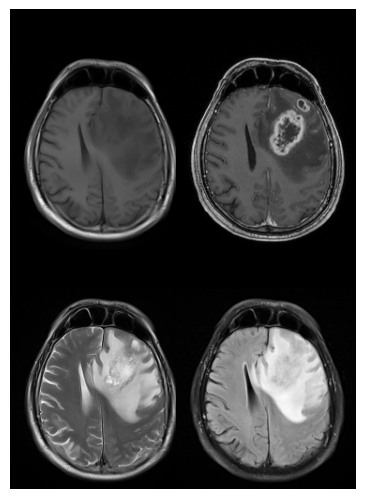

In [22]:
case_id = "IM0031"
plot_four_figures(case_id, t1_im_dir, t1gd_im_dir, t2_im_dir, flair_im_dir, slice_number=361, wspace=-0.65, hspace=0, output_dir=Path(output_dir), together=True)

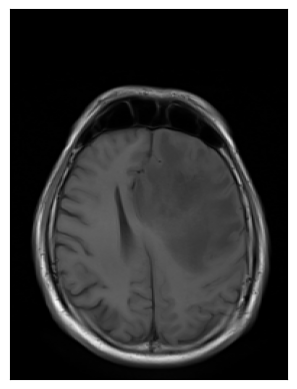

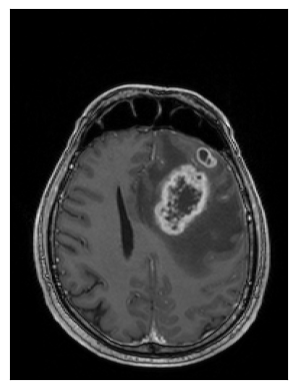

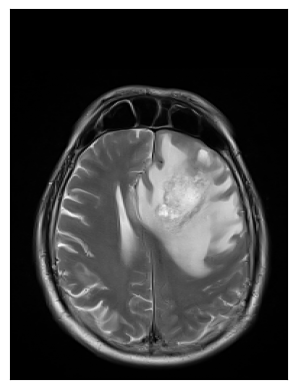

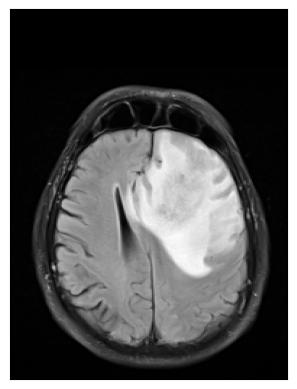

In [23]:
case_id = "IM0031"
plot_four_figures(case_id, t1_im_dir, t1gd_im_dir, t2_im_dir, flair_im_dir, slice_number=361, together=False)

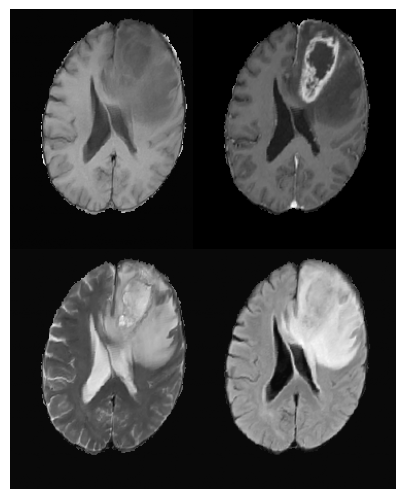

In [24]:
case_id = "IM0031"
t1_im_dir_atlas = patients_dir / case_id / "REGISTRATION" / "ATLAS_MNI152_SKULLSTRIP" / "T1.nii.gz"
t1gd_im_dir_atlas = patients_dir / case_id / "REGISTRATION" / "ATLAS_MNI152_SKULLSTRIP" / "T1GD.nii.gz"
t2_im_dir_atlas = patients_dir / case_id / "REGISTRATION" / "ATLAS_MNI152_SKULLSTRIP" / "T2.nii.gz"
flair_im_dir_atlas = patients_dir / case_id / "REGISTRATION" / "ATLAS_MNI152_SKULLSTRIP" / "FLAIR.nii.gz"

plot_four_figures(case_id, t1_im_dir_atlas, t1gd_im_dir_atlas, t2_im_dir_atlas, flair_im_dir_atlas, slice_number=int(189/2), wspace=-0.6, hspace=0, output_dir=Path(output_dir))

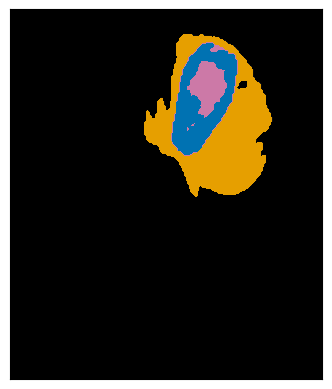

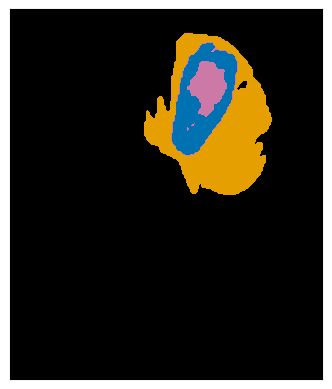

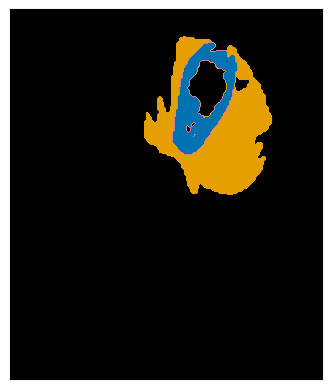

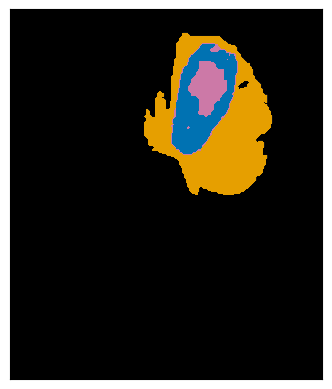

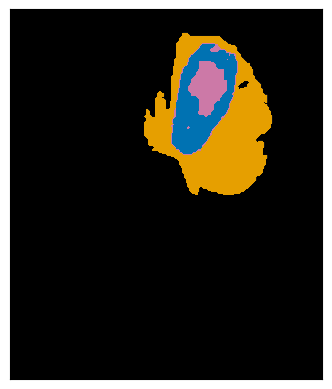

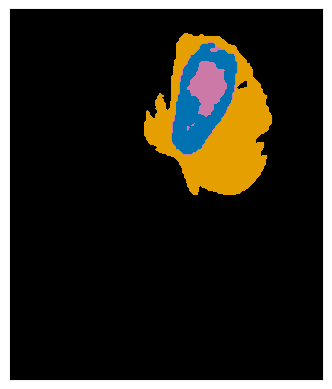

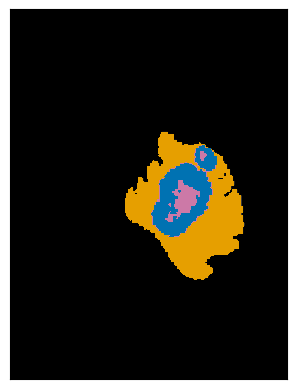

In [25]:
# Now we will plot the segmentations for each of the models 
case_id = "IM0031"
segmentation_nnunet_dir = patients_dir /case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_nnunet_ensemble_task_001_082.nii.gz"
segmentation_brats21_dir = patients_dir / case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_nnunet_task500_ensemble.nii.gz"
segmentation_hdglio_dir = patients_dir / case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_hdglio.nii.gz"
segmentation_deepscan_dir = patients_dir / case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_scan2020.nii.gz"
segmentation_fets_dir = patients_dir / case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_scan2020.nii.gz"
staple_segmentation_dir = patients_dir / case_id / "SEGMENTATIONS" / "ATLAS" / "mask_tumor_ensemble_relabelled.nii.gz"
staple_segmentation_nifti_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

slice_number = int(189/2)

segmentation_nnunet, _ = reorient_image_to_itk_snap_view(segmentation_nnunet_dir)
segmentation_brats21, _ = reorient_image_to_itk_snap_view(segmentation_brats21_dir) 
segmentation_hdglio, _ = reorient_image_to_itk_snap_view(segmentation_hdglio_dir)
segmentation_deepscan, _ = reorient_image_to_itk_snap_view(segmentation_deepscan_dir)
segmentation_fets, _ = reorient_image_to_itk_snap_view(segmentation_fets_dir)
staple_segmentation, _ = reorient_image_to_itk_snap_view(staple_segmentation_dir)
staple_segmentation_nifti_dir, aspect_staple_segmentation_nifti = reorient_image_to_itk_snap_view(staple_segmentation_nifti_dir)

plt.figure()
plt.imshow(segmentation_nnunet[:, :, slice_number], cmap="gray")
plt.contourf(
    segmentation_nnunet[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_nnunet_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure()
plt.imshow(segmentation_brats21[:, :, slice_number], cmap="gray")
plt.contourf(
    segmentation_brats21[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_brats21_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()  

plt.figure()
plt.imshow(segmentation_hdglio[:, :, slice_number], cmap="gray")
plt.contourf(
    segmentation_hdglio[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_hdglio_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()  

plt.figure()
plt.imshow(segmentation_deepscan[:, :, slice_number], cmap="gray")
plt.contourf(
    segmentation_deepscan[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_deepscan_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure()
plt.imshow(segmentation_fets[:, :, slice_number], cmap="gray")
plt.contourf(
    segmentation_fets[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_fets_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure()
plt.imshow(staple_segmentation[:, :, slice_number], cmap="gray")
plt.contourf(
    staple_segmentation[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_staple_segmentation_slice_{slice_number}.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure()
plt.imshow(staple_segmentation_nifti_dir[:, :, 361], cmap="gray", aspect=aspect_staple_segmentation_nifti)
plt.contourf(
    staple_segmentation_nifti_dir[:, :, 361],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_staple_segmentation_nifti_slice_{361}.svg", bbox_inches="tight", pad_inches=0)
plt.show()


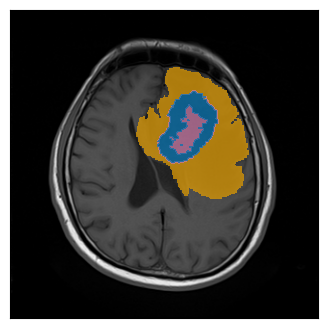

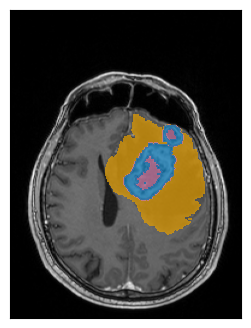

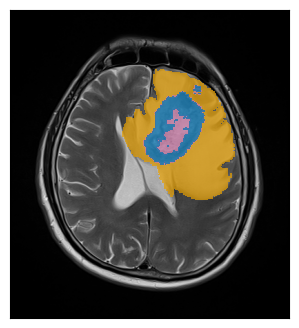

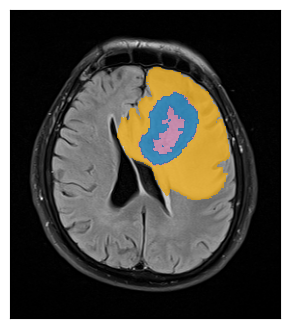

In [26]:
# Framework figures for paper

output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)

patients_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")

case_id = "IM0031"


# First: raw data 

t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
t1_seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1.nii.gz"
t1_im, t1_aspect = reorient_image_to_itk_snap_view(t1_im_dir)
t1_seg, _ = reorient_image_to_itk_snap_view(t1_seg_dir)
plt.figure(figsize=(4,4))
plt.imshow(t1_im[:, :, 15], cmap="gray", aspect=t1_aspect)
plt.contourf(
    t1_seg[:, :, 15],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=0.7
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T1_slice_15_with_GT.svg", bbox_inches="tight", pad_inches=0)
plt.show()


t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
t1gd_seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1GD.nii.gz"
t1gd_im, t1gd_aspect = reorient_image_to_itk_snap_view(t1gd_im_dir)
t1gd_seg, _ = reorient_image_to_itk_snap_view(t1gd_seg_dir)
plt.figure(figsize=(4,4))
plt.imshow(t1gd_im[:, :, 352], cmap="gray", aspect=t1gd_aspect)
plt.contourf(
    t1gd_seg[:, :, 352],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=0.7
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T1GD_slice_352_with_GT.svg", bbox_inches="tight", pad_inches=0)
plt.show()

t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
t2_seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T2.nii.gz"
t2_im, t2_aspect = reorient_image_to_itk_snap_view(t2_im_dir)
t2_seg, _ = reorient_image_to_itk_snap_view(t2_seg_dir)
plt.figure(figsize=(4,4))
plt.imshow(t2_im[:, :, 15], cmap="gray", aspect=t2_aspect)
plt.contourf(
    t2_seg[:, :, 15],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=0.7
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_T2_slice_15_with_GT.svg", bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure(figsize=(4,4))
flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"
flair_seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_FLAIR.nii.gz"
flair_im, flair_aspect = reorient_image_to_itk_snap_view(flair_im_dir)
flair_seg, _ = reorient_image_to_itk_snap_view(flair_seg_dir)
plt.imshow(flair_im[:, :, 15], cmap="gray", aspect=flair_aspect)
plt.contourf(
    flair_seg[:, :, 15],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=0.7
)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(output_dir) / f"{case_id}_FLAIR_slice_15_with_GT.svg", bbox_inches="tight", pad_inches=0)
plt.show()


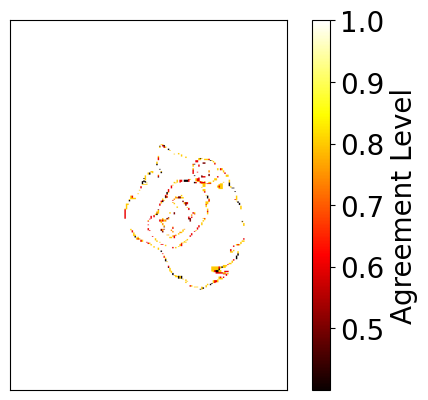

In [27]:
# Now we are going to plot the heatmap in hot cmap 

heatmap_referral_case_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/SEG_QA/AGREEMENT_STAPLE_HEATMAP/IM0031_T1GD.nii.gz")
heatmap_im, heatmap_aspect = reorient_image_to_itk_snap_view(heatmap_referral_case_dir)
# heatmap_im = np.ma.masked_where(heatmap_im == 0, heatmap_im)
plt.imshow(heatmap_im[:, :, 352 ], cmap="hot", aspect=heatmap_aspect)
# add the colorbar 
cbar = plt.colorbar()
cbar.set_label("Agreement Level", fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig("/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES/IM0031_agreement_heatmap_slice_352.svg", bbox_inches="tight", pad_inches=0)
plt.show()

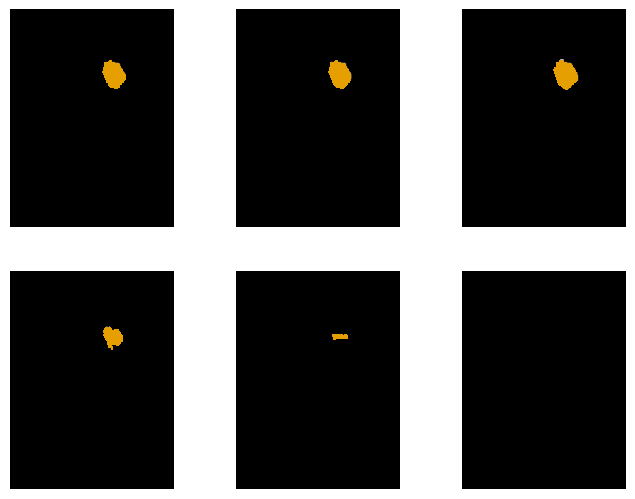

In [28]:
# Now we will plot the segmentations for each of the models 
case_id = "IM1411"
segmentation_nnunet_dir = patients_dir /case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_nnunet_ensemble_task_001_082_relabelled_T1GD.nii.gz"
segmentation_brats21_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_nnunet_task500_ensemble_relabelled_T1GD.nii.gz"
segmentation_hdglio_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_hdglio_relabelled_T1GD.nii.gz"
segmentation_deepscan_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_scan2020_relabelled_T1GD.nii.gz"
segmentation_fets_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_fets_relabelled_T1GD.nii.gz"
staple_segmentation_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

slice_number = 157

segmentation_nnunet, _ = reorient_image_to_itk_snap_view(segmentation_nnunet_dir)
segmentation_brats21, _ = reorient_image_to_itk_snap_view(segmentation_brats21_dir) 
segmentation_hdglio, _ = reorient_image_to_itk_snap_view(segmentation_hdglio_dir)
segmentation_deepscan, _ = reorient_image_to_itk_snap_view(segmentation_deepscan_dir)
segmentation_fets, _ = reorient_image_to_itk_snap_view(segmentation_fets_dir)
staple_segmentation, _ = reorient_image_to_itk_snap_view(staple_segmentation_dir)


fig = plt.figure()
gs = fig.add_gridspec(
    2, 3,
    left=0, right=1, bottom=0, top=1,
    # wspace=-0.56, hspace=-0.2
)
axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(3)] for r in range(2)])

axes[0,0].imshow(staple_segmentation[:, :, slice_number], cmap="gray")
axes[0,0].contourf(
    staple_segmentation[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,0].axis("off")

axes[0,1].imshow(segmentation_brats21[:, :, slice_number], cmap="gray")
axes[0,1].contourf(
    segmentation_brats21[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,1].axis("off")

axes[0,2].imshow(segmentation_deepscan[:, :, slice_number], cmap="gray")
axes[0,2].contourf(
    segmentation_deepscan[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,2].axis("off")

axes[1,0].imshow(segmentation_nnunet[:, :, slice_number], cmap="gray")
axes[1,0].contourf(
    segmentation_nnunet[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,0].axis("off")  

axes[1,1].imshow(segmentation_hdglio[:, :, slice_number], cmap="gray")
axes[1,1].contourf(
    segmentation_hdglio[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,1].axis("off")

axes[1,2].imshow(segmentation_fets[:, :, slice_number], cmap="gray")
axes[1,2].contourf(
    segmentation_fets[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,2].axis("off")
plt.savefig(Path(output_dir) / f"{case_id}_candidate_segmentations_all.svg", bbox_inches="tight", pad_inches=0)
plt.show()

In [29]:
import pandas as pd 
multiclass_dice_data = pd.read_excel("/scratch/radv/share/glioseg/new_run_corrected/VALIDATION/METRICS/additional_validation_metrics.xlsx", sheet_name="Multiclass dice score", skiprows=1)
im1411_info = multiclass_dice_data.loc[multiclass_dice_data.iloc[:, 0] == "IM1411"]
im1411_info = im1411_info.loc[:, im1411_info.columns.str.contains("relabeled(?!_cc)")]
print(im1411_info)

    nnUNet task 001-082_relabeled  nnUNet task 500_relabeled  \
45                          0.702                       0.85   

    HDglio_relabeled  DeepSCAN_relabeled  FETS_relabeled  MV_relabeled  \
45             0.157               0.835             0.0         0.702   

    STAPLE_relabeled  SIMPLE_relabeled  SIMPLE_TN_relabeled  
45             0.848             0.848                0.848  


In [30]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


def plot_one_case(
    case_id: str,
    patients_dir: str | Path,
    gt_dir: str | Path,
    slice_number: int,
    output_dir: str | Path = None,
    **kwargs
):
    """
    Plot T1, T1CE, T2, FLAIR with GT and ensemble overlayed in T1CE
    """

    patients_dir = Path(patients_dir)
    gt_dir = Path(gt_dir)
    if output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
    
    fig = plt.figure()
    gs = fig.add_gridspec(
        1, 6,
        left=0, right=1, bottom=0, top=1,
        **kwargs
    )

    axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(6)] for r in range(1)])

    # ---------------------------
    # File paths
    # ---------------------------

    t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD_original.nii.gz"
    t1_im_dir = patients_dir / case_id / "NIFTI" / "T1_original.nii.gz"
    t2_im_dir = patients_dir / case_id / "NIFTI" / "T2_original.nii.gz"
    flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR_original.nii.gz"

    if not t1gd_im_dir.exists():
        t1gd_im_dir = patients_dir / case_id / "NIFTI" / "T1GD.nii.gz"
    if not t1_im_dir.exists():
        t1_im_dir = patients_dir / case_id / "NIFTI" / "T1.nii.gz"
    if not t2_im_dir.exists():
        t2_im_dir = patients_dir / case_id / "NIFTI" / "T2.nii.gz"
    if not flair_im_dir.exists():
        flair_im_dir = patients_dir / case_id / "NIFTI" / "FLAIR.nii.gz"

    seg_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / \
            "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

    gt_mask = gt_dir / case_id / "NIFTI" / "MASK.nii.gz"

    # ---------------------------
    # Read images
    # ---------------------------
    t1gd_itk = sitk.ReadImage(t1gd_im_dir)
    t1_itk = sitk.ReadImage(t1_im_dir)
    t2_itk = sitk.ReadImage(t2_im_dir)
    flair_itk = sitk.ReadImage(flair_im_dir)

    # Resample all to T1GD space
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(t1gd_itk)
    resampler.SetInterpolator(sitk.sitkLinear)

    t1_itk = resampler.Execute(t1_itk)
    t2_itk = resampler.Execute(t2_itk)
    flair_itk = resampler.Execute(flair_itk)

    # ---------------------------
    # Convert + reorient
    # ---------------------------
    t1gd_im, orig_aspect = reorient_image_to_itk_snap_view(t1gd_itk)
    t1_im, _ = reorient_image_to_itk_snap_view(t1_itk)
    t2_im, _ = reorient_image_to_itk_snap_view(t2_itk)
    flair_im, _ = reorient_image_to_itk_snap_view(flair_itk)
    seg_im, _ = reorient_image_to_itk_snap_view(seg_dir)
    gt_im, _ = reorient_image_to_itk_snap_view(gt_mask)

    # ---------------------------
    # Overlay colors (Okabe–Ito safe)
    # ---------------------------
    colors = ["#E69F00", "#CC79A7", "#0072B2"]  # orange, purple, blue
    levels = [0.5, 1.5, 2.5, 3.5]

    # ---------------------------
    # Plot helper
    # ---------------------------
    def show(ax, base, overlay=None):
        ax.axis("off")
        ax.imshow(base[:, :, slice_number], cmap="gray", aspect=orig_aspect)
        if overlay is not None:
            ax.contourf(
                overlay[:, :, slice_number],
                levels=levels,  
                colors=colors,
                alpha=0.7
            )


    slice_number

    # Row — T1, T1CE, T2, FLAIR, GT overlay, SEG overlay
    show(axes[0, 0], t1_im)
    show(axes[0, 1], t1gd_im)
    show(axes[0, 2], t2_im)
    show(axes[0, 3], flair_im)
    show(axes[0, 4], t1gd_im, gt_im)
    show(axes[0, 5], t1gd_im, seg_im)
    
    plt.savefig(
        output_dir / f"{case_id}_slice_{slice_number}_segmentation_and_gt_overlayed.svg",
        bbox_inches="tight",
        pad_inches=0,
    )
    plt.show()

<Figure size 640x480 with 0 Axes>

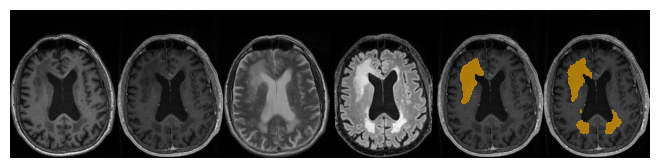

<Figure size 640x480 with 0 Axes>

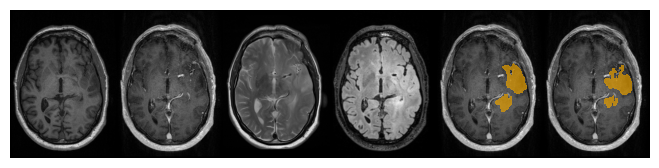

<Figure size 640x480 with 0 Axes>

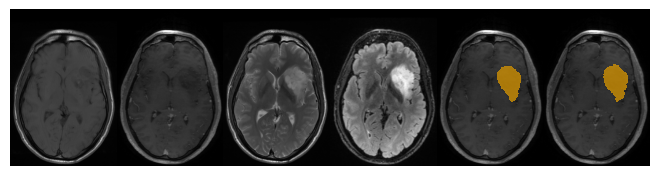

<Figure size 640x480 with 0 Axes>

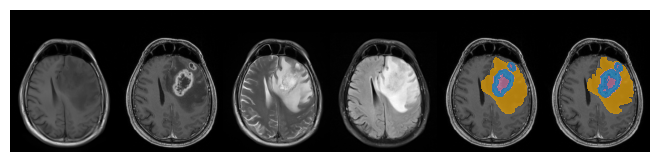

<Figure size 640x480 with 0 Axes>

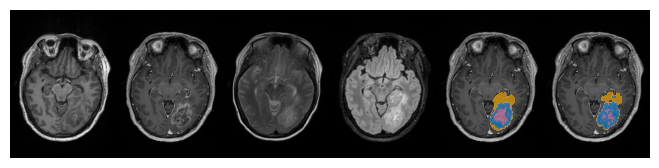

In [31]:
patients_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients"
output_dir = "/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES"
Path(output_dir).mkdir(parents=True, exist_ok=True)
gt_dir = "/scratch/radv/share/glioseg/new_run_corrected/GT"
case_ids = ["IM1392", "IM1389", "IM0256", "IM0031", "IM1420"]
slice_numbers = [148, 139, 260, 361, 126]

for case_id, slice_number in zip(case_ids, slice_numbers):
    plt.figure()
    plot_one_case(
        case_id,
        patients_dir,
        gt_dir,
        slice_number,
        output_dir,
        wspace = 0, 
        hspace = 0
    )
    plt.close()

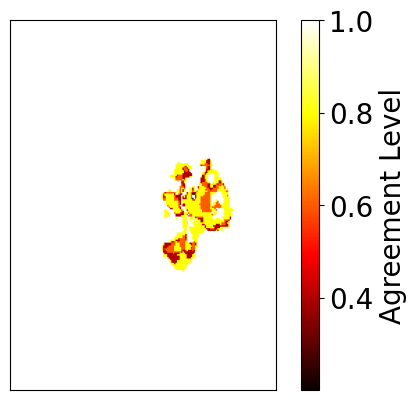

In [32]:
heatmap_worst_case_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/SEG_QA/AGREEMENT_STAPLE_HEATMAP/IM1389_T1GD.nii.gz")
heatmap_im, heatmap_aspect = reorient_image_to_itk_snap_view(heatmap_worst_case_dir)
# heatmap_im = np.ma.masked_where(heatmap_im == 0, heatmap_im)
plt.imshow(heatmap_im[:, :, 139], cmap="hot", aspect=heatmap_aspect)
# add the colorbar 
cbar = plt.colorbar()
cbar.set_label("Agreement Level", fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig("/scratch/radv/share/glioseg/new_run_corrected/PAPER_FIGURES/IM1389_agreement_heatmap_slice_139.svg", bbox_inches="tight", pad_inches=0)
plt.show()

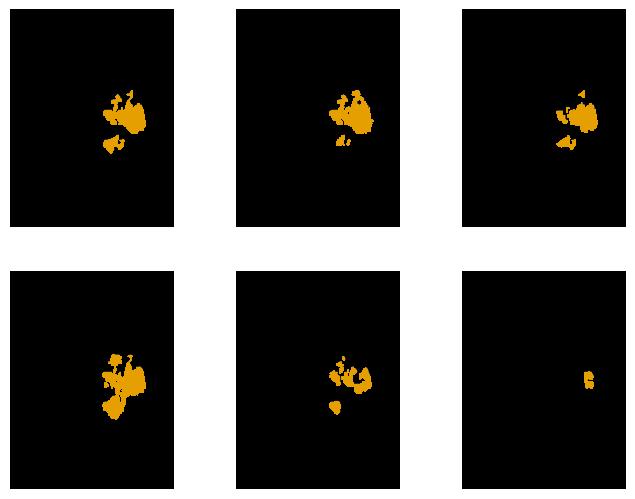

In [33]:
# Now we will plot the segmentations for each of the models 
case_id = "IM1389"
patients_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")
segmentation_nnunet_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_nnunet_ensemble_task_001_082_relabelled_T1GD.nii.gz"
segmentation_brats21_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_nnunet_task500_ensemble_relabelled_T1GD.nii.gz"
segmentation_hdglio_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_hdglio_relabelled_T1GD.nii.gz"
segmentation_deepscan_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_scan2020_relabelled_T1GD.nii.gz"
segmentation_fets_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_fets_relabelled_T1GD.nii.gz"
staple_segmentation_dir = patients_dir / case_id / "SEGMENTATIONS" / "NIFTI" / "mask_tumor_ensemble_relabelled_T1GD.nii.gz"

slice_number = 139

segmentation_nnunet, _ = reorient_image_to_itk_snap_view(segmentation_nnunet_dir)
segmentation_brats21, _ = reorient_image_to_itk_snap_view(segmentation_brats21_dir) 
segmentation_hdglio, _ = reorient_image_to_itk_snap_view(segmentation_hdglio_dir)
segmentation_deepscan, _ = reorient_image_to_itk_snap_view(segmentation_deepscan_dir)
segmentation_fets, _ = reorient_image_to_itk_snap_view(segmentation_fets_dir)
staple_segmentation, _ = reorient_image_to_itk_snap_view(staple_segmentation_dir)


fig = plt.figure()
gs = fig.add_gridspec(
    2, 3,
    left=0, right=1, bottom=0, top=1,
    # wspace=-0.56, hspace=-0.2
)
axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(3)] for r in range(2)])

axes[0,0].imshow(staple_segmentation[:, :, slice_number], cmap="gray")
axes[0,0].contourf(
    staple_segmentation[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,0].axis("off")

axes[0,1].imshow(segmentation_brats21[:, :, slice_number], cmap="gray")
axes[0,1].contourf(
    segmentation_brats21[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,1].axis("off")

axes[0,2].imshow(segmentation_deepscan[:, :, slice_number], cmap="gray")
axes[0,2].contourf(
    segmentation_deepscan[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[0,2].axis("off")

axes[1,0].imshow(segmentation_nnunet[:, :, slice_number], cmap="gray")
axes[1,0].contourf(
    segmentation_nnunet[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,0].axis("off")  

axes[1,1].imshow(segmentation_hdglio[:, :, slice_number], cmap="gray")
axes[1,1].contourf(
    segmentation_hdglio[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,1].axis("off")

axes[1,2].imshow(segmentation_fets[:, :, slice_number], cmap="gray")
axes[1,2].contourf(
    segmentation_fets[:, :, slice_number],
    levels=[0.5, 1.5, 2.5, 3.5],
    colors=["#E69F00", "#CC79A7", "#0072B2"],
    alpha=1
)
axes[1,2].axis("off")
plt.savefig(Path(output_dir) / f"{case_id}_candidate_segmentations_all.svg", bbox_inches="tight", pad_inches=0)
plt.show()